In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Section

In [2]:
!pip install torchtext==0.6.0 # need to run and restart runtime for TabularDataset, Field and LabelField imports

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.3 MB/s 
     |████████████████████████████████| 1.3 MB 14.7 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1


In [3]:
### LIBRARY IMPORTS ###
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchtext
#import torchtext.data as data
from torchtext.data import get_tokenizer, TabularDataset, Field, LabelField
import torchvision.datasets as datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import spacy   # may be unused not sure currently
import nltk
import random

#import torchtext.data as data
#from spacy.en import English

In [32]:
glove = torchtext.vocab.GloVe(name="twitter.27B", # trained on Wikipedia 2014 corpus
                              dim=200)   # embedding size = 50

.vector_cache/glove.twitter.27B.zip: 1.52GB [04:44, 5.34MB/s]                            
100%|█████████▉| 1193513/1193514 [01:20<00:00, 14763.41it/s]


In [5]:
#glove2 =torchtext.vocab.GloVe(name="840B", # trained on Wikipedia 2014 corpus
#                              dim=200)   # embedding size = 50

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
!pip install spacey

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 7.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [10]:
data_fr   = pd.read_csv("//content//fr_train_df.csv")
data_es   = pd.read_csv("//content//es_train_df.csv")
data_it   = pd.read_csv("//content//it_train_df.csv")
data_nl   = pd.read_csv("//content//nl_train_df.csv")
data_de   = pd.read_csv("//content//de_train_df.csv")
data_ch   = pd.read_csv("//content//ch_train_df.csv")
data_ar   = pd.read_csv("//content//ar_train_df.csv")
data_orig = pd.read_csv(   "//content//train_df.csv")


In [11]:
data = pd.concat([data_it, data_de, data_ch, data_ar, data_orig])
print(data.head())
print(data_orig.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our actions are the reason for this #Earthquak...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents who have been asked to "take ref...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  I just got this photo from Ruby #Alaska as smo...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

  

In [12]:
data2 = pd.read_csv("//content//train.csv")
#data = pd.read_csv("//content//inf_past_decade.csv")
#data = pd.read_csv("//content//Data50k.csv")
len(data2[data2["target"]==1])

3271

In [13]:

for i, dis in enumerate(np.array(data2[data2["target"]==1][:]),0):
  if i % 3 == 0:
    #print(dis.tolist())
    dis_dict = {}
    for j, elem in enumerate(dis, 0):
      dis_dict[data2.columns[j]] = elem
    #pd.DataFrame(dis)
    #print(dis_dict)
    data2 = data2.append(dis_dict, ignore_index=True)
    #break
  
#len(data2[data2["target"]==1])
#data2[data2["target"]==1]
data2

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
8699,10855,NaN,NaN,Evacuation order lifted for town of Roosevelt:...,1
8700,10862,NaN,NaN,Officials say a quarantine is in place at an A...,1
8701,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1
8702,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1


In [14]:
len(data2[data2["target"]==1])

4362

In [15]:
data2 = data2.sample(frac=1).reset_index(drop=True)
data2

,id,keyword,location,text,target
0,8433,sandstorm,USA,Watch This Airport Get Swallowed Up By A Sands...,1
1,9466,terrorism,NaN,DHS Refuses to Call Chattanooga Û÷Islamic Ter...,1
2,5943,hazard,Arizona,Get that hazard pay,0
3,4901,explode,NaN,All these people explode ????,0
4,9765,trapped,10 Steps Ahead. Cloud 9,Bomb head? Explosive decisions dat produced mo...,1
...,...,...,...,...,...
8699,7742,panicking,NaN,you can stop panicking ?????? @ogtomd https:/...,0
8700,8742,siren,nc,I just made a weird high pitched noise and the...,0
8701,8024,refugees,NaN,reaad/ plsss 12000 Nigerian refugees repatriat...,1
8702,8841,sirens,NaN,It's 'Run From Sirens' by 'Half Hour Hotel' @h...,0


In [16]:
data_reduced = data2[["text", "target"]]
data_reduced_val = pd.read_csv("valid_df.csv")[["text", "target"]]
data_reduced_test = pd.read_csv("test_df.csv")[["text", "target"]]


In [17]:
len(data_reduced)

8704

In [18]:
data_reduced.tail()

,text,target
8699,you can stop panicking ?????? @ogtomd https:/...,0
8700,I just made a weird high pitched noise and the...,0
8701,reaad/ plsss 12000 Nigerian refugees repatriat...,1
8702,It's 'Run From Sirens' by 'Half Hour Hotel' @h...,0
8703,Two giant cranes holding a bridge collapse int...,1


In [19]:
# convert to tabular dataset
data_reduced.to_csv("tokenized_data.csv", index=None)
data_reduced_val.to_csv("tokenized_val_data.csv", index=None)
data_reduced_test.to_csv("tokenized_test_data.csv", index=None)
tokenised_data = Field(tokenize="spacy", use_vocab=True, tokenizer_language="en_core_web_sm")
# https://github.com/pytorch/text/issues/78
labels = LabelField(dtype = torch.float, use_vocab=False, preprocessing=float)#, postprocessing=torchtext.data.Pipeline(lambda x: float(x))) # converting string ratios to doubles and not using a vocab for target labels
dataset = TabularDataset(path="tokenized_data.csv", format="CSV", fields=[("tweet", tokenised_data),("label", labels)],skip_header=True)
dataset_valid = TabularDataset(path="tokenized_val_data.csv", format="CSV", fields=[("tweet", tokenised_data),("label", labels)],skip_header=True)
dataset_test = TabularDataset(path="tokenized_test_data.csv", format="CSV", fields=[("tweet", tokenised_data),("label", labels)],skip_header=True)
vars(dataset_valid[0])

{'label': 0.0,
 'tweet': ['Next',
  'Man',
  'Up',
  '---',
  'AH',
  'SCREW',
  'THIS',
  '!',
  'I',
  "'m",
  'so',
  'tired',
  'of',
  'injuries',
  '.',
  ' \n\n',
  'What',
  'happened',
  'to',
  'Camp',
  'Cupcake',
  '?',
  'More',
  'like',
  'Camp',
  'Cramp',
  'and',
  'Break',
  '.']}

In [20]:
train_set, val_set, test_set = dataset.split(split_ratio=[0.74, 0.13, 0.13],random_state=random.seed(0))  
#train_set = dataset
#val_set = dataset_valid
#test_set = dataset_test
sanity_set, _ = val_set.split(split_ratio=[0.004,0.996],random_state=random.seed(0))  

In [21]:
tokenised_data.build_vocab(train_set, max_size=30000) # dictionary stores a maximum of 50000 words as to get the jist of the tweets while saving space.
labels.build_vocab(train_set) 
print(len(tokenised_data.vocab))
tokenised_data.vocab.freqs.most_common(20)
tokenised_data.vocab.itos[21]


22121


'you'

In [22]:
# def dim(a):
#     if not type(a) == list and not type(a) == torch.float32:
#         return []
#     return [len(a)] + dim(a[0])

# nn_embedding_vocab = [glove[word] for word in tokenised_data.vocab.itos]
# print(dim(nn_embedding_vocab))
# words = [word for word in tokenised_data.vocab.itos]
#nn_embedding_vocab = torch.Tensor(np.array(nn_embedding_vocab, dtype=np.float64))
#indices = nn_embedding_vocab.where(nn_embedding_vocab[0])
#indices = [i for i, x in enumerate(nn_embedding_vocab) if x == nn_embedding_vocab[0]]
#print(nn_embedding_vocab.index(nn_embedding_vocab[0]))
    #[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,0., 0.]))
#print(words[0])
#print(indices)

In [23]:
print(len(train_set), len(val_set), len(test_set), len(sanity_set))

6441 1131 1132 5


In [24]:
train_loader  = torchtext.data.BucketIterator( train_set, batch_size=5, device = device, shuffle=True, sort_key = lambda x: len(x.tokenized_tweets), sort_within_batch=False)
val_loader    = torchtext.data.BucketIterator(   val_set, batch_size=5, device = device, shuffle=True, sort_key = lambda x: len(x.tokenized_tweets), sort_within_batch=False)
test_loader   = torchtext.data.BucketIterator(  test_set, batch_size=5, device = device, shuffle=True, sort_key = lambda x: len(x.tokenized_tweets), sort_within_batch=False)
sanity_loader = torchtext.data.BucketIterator(sanity_set, batch_size=5, device = device, shuffle=True, sort_key = lambda x: len(x.tokenized_tweets), sort_within_batch=False) # lambda x: len(x.tokenized_tweets)
sanity_set

In [25]:
#for data in sanity_loader:
#  break
for i, data in enumerate(sanity_loader, 0):
  text, label = data
  print(label) 
  print(text)      # each column represents 1 tweet, each word coded to one integer. 1s represent sentence padding, each batch has different sentence lengths
  
  break

tensor([1., 1., 1., 0., 0.], device='cuda:0')
tensor([[    2,   294,     2,     0,   116],
        [ 1235,   352,   758,    18,   643],
        [   15,  6619,   383,   263,     6],
        [   12,    20,  1263,    54,     0],
        [   48,  1286, 20765,   302,     0],
        [   33,    10,  1189,    29,     0],
        [  929,  1501,   666,  2353,    18],
        [   39,   134,   806,    18,  3762],
        [    4,  1339,   674,     0,  2116],
        [    2,   208,   681,     4,   349],
        [ 3109,   932, 17230,     0,     0],
        [ 4339,    13,     1,     4,     0],
        [   22, 20058,     1,   198,     1],
        [    2,     8,     1,    33,     1],
        [    0,    16,     1,  1624,     1],
        [    2,    11,     1,     0,     1],
        [  592, 16951,     1,    19,     1],
        [    2, 18402,     1,     0,     1],
        [    0,    84,     1,    15,     1],
        [    2,     2,     1,     0,     1],
        [    0, 11469,     1,     1,     1],
        [

# The different models we have done testing with

In [26]:
from torch.nn.modules import dropout
class RatioNet(nn.Module):
  def __init__(self, input_size, batch_size, device, hidden_size=50, embedding_size=20, lstm_input_size=100, num_layers = 2, dropout=0.5, bi_direc=True):
    super(RatioNet, self).__init__()

    self.name = "RatioNet"
    self.device =device
    self.bs = batch_size
    self.lstmis = lstm_input_size
    self.hs = hidden_size
    self.nl = num_layers
    self.bd = bi_direc

    self.embedding = nn.Embedding(input_size, embedding_size)  # sequence size (padded tweet length), batch_size, embedding size (ie vector representation of integer words)

    self.conv1 = nn.Conv1d(embedding_size, 200, 3)
    o = (64 - 3)//1 + 1         # conv1 output size
    #o = (o - 2)//2 + 1                      # maxpool output size
    #print(o)

    self.conv2 = nn.Conv1d(200, 250, 3)
    o = (o - 3)//1 + 1                      # conv2 output size
    #o = (o - 2)//2 + 1                      # maxpool output size
    #print(o)

    self.conv3 = nn.Conv1d(250, self.lstmis, 3)
    o = (o - 3)//1 + 1                      # conv3 output size
    #print(o)
    self.maxpool = nn.MaxPool1d(2, 2)
    lstm_input_size = (o - 2)//2 + 1        # maxpool output size
    #print(lstm_input_size, "word reduction")

    self.stacked_LSTM = nn.LSTM(input_size = self.lstmis, hidden_size = self.hs, num_layers = self.nl, batch_first=True, dropout=dropout, bidirectional=bi_direc) # batch_first==True >>> (batch, seq, features) , batch_first==False (seq, batch, feature)
    
    self.output_layer = nn.Linear(self.hs * (self.bd + 1), 2)
    
  def forward(self, x):
    # convert integer coded tweets to embeddings
    x = self.embedding(x)
    x = x.permute(1, 2, 0)   # convert to (batch_size, embedding dimension, number of words) order to feed into conv layers (embedding dimension == # channels)
    
    #print(x.size(), "permute")
    x = (F.relu(self.conv1(x)))
    x = (F.relu(self.conv2(x)))
    x = self.maxpool(F.relu(self.conv3(x)))
    #print(x.size())

    x = x.permute(0, 2, 1) # convert to (batch_size, number of words, embedding dimension) order to feed into stacked lstm layer (batch_first set to True) 

    h_0 = torch.ones(self.nl * (int(self.bd)+1), x.shape[0], self.hs).to(self.device)
    c_0 = torch.ones(self.nl * (int(self.bd)+1), x.shape[0], self.hs).to(self.device)
    x, (h_n, c_n) = self.stacked_LSTM(x, (h_0, c_0))  # output, hidden state, cell state
    # if you visualize the lstm you can see that x[:,-1,:] (output from the final word) is the same as the output of the second hidden layer output (only for non-bidirectional LSTMs)
    # print(h_n[-1]==x[:,-1,:])
    #print(x.size())
    #print(h_n.size())
    
    # passing lstm final output into output layer for ratio prediction
    #out = F.relu(self.output_layer(h_n[-1])) # output should be above 0 but unbounded above pass in final hidden layer
    out = self.output_layer(x[:,-1,:])
    
    return out

In [29]:
class IGRatioNet(nn.Module):
  def __init__(self, input_size, batch_size, device, hidden_size=50, embedding_size=20, lstm_input_size=100, num_layers = 2, dropout=0.5, bi_direc=True):
    super(IGRatioNet, self).__init__()

    self.name = "IGRatioNet"
    self.device =device
    self.bs = batch_size
    self.lstmis = lstm_input_size
    self.hs = hidden_size
    self.nl = num_layers
    self.bd = bi_direc

    self.embedding = nn.Embedding.from_pretrained(glove.vectors)  # sequence size (padded tweet length), batch_size, embedding size (ie vector representation of integer words)

    self.conv1 = nn.Conv1d(embedding_size, 200, 3, padding=1)
    o = (64 - 3)//1 + 1         # conv1 output size
    #o = (o - 2)//2 + 1                      # maxpool output size
    #print(o)

    self.conv2 = nn.Conv1d(200, 250, 3, padding=1)
    o = (o - 3)//1 + 1                      # conv2 output size
    #o = (o - 2)//2 + 1                      # maxpool output size
    #print(o)

    self.conv3 = nn.Conv1d(250, self.lstmis, 3, padding=1)
    o = (o - 3)//1 + 1                      # conv3 output size
    #print(o)
    self.maxpool = nn.MaxPool1d(2, 2)
    lstm_input_size = (o - 2)//2 + 1        # maxpool output size
    #print(lstm_input_size, "word reduction")

    self.stacked_LSTM = nn.LSTM(input_size = self.lstmis, hidden_size = self.hs, num_layers = self.nl, batch_first=True, dropout=dropout, bidirectional=bi_direc) # batch_first==True >>> (batch, seq, features) , batch_first==False (seq, batch, feature)
    
    self.output_layer = nn.Linear(self.hs * 2 * (self.bd + 1), 2)
    
  def forward(self, x):
    # convert integer coded tweets to embeddings
    x = self.embedding(x)
    x = x.permute(0, 2, 1)   # convert to (batch_size, embedding dimension, number of words) order to feed into conv layers (embedding dimension == # channels)
    
    #print(x.size(), "permute")
    
    x = (F.relu(self.conv1(x)))
    x = (F.relu(self.conv2(x)))
    x = (F.relu(self.conv3(x)))#self.maxpool(F.relu(self.conv3(x)))

    #print(x.size())

    x = x.permute(0, 2, 1) # convert to (batch_size, number of words, embedding dimension) order to feed into stacked lstm layer (batch_first set to True) 

    h_0 = torch.ones(self.nl * (int(self.bd)+1), x.shape[0], self.hs).to(self.device)
    c_0 = torch.ones(self.nl * (int(self.bd)+1), x.shape[0], self.hs).to(self.device)
    x, (h_n, c_n) = self.stacked_LSTM(x, (h_0, c_0))  # output, hidden state, cell state
    # if you visualize the lstm you can see that x[:,-1,:] (output from the final word) is the same as the output of the second hidden layer output (only for non-bidirectional LSTMs)
    # print(h_n[-1]==x[:,-1,:])
    #print(x.size())
    #print(h_n.size())
    
    # passing lstm final output into output layer for ratio prediction
    #out = F.relu(self.output_layer(h_n[-1])) # output should be above 0 but unbounded above pass in final hidden layer
    #out = self.output_layer(x[:,-1,:])
    out = torch.cat([torch.max(x, dim=1)[0], 
                      torch.mean(x, dim=1)], dim=1) 
    out = self.output_layer(out)   
    return out

In [33]:
class ANNRatioNet(nn.Module):
  def __init__(self, input_size, batch_size, device, hidden_size=50, embedding_size=20, lstm_input_size=100, num_layers = 2, dropout=0.5, bi_direc=True):
    super(RatioNet, self).__init__()

    self.name = "ANNRatioNet"
    self.device =device
    self.bs = batch_size
    self.lstmis = lstm_input_size
    self.hs = hidden_size
    self.nl = num_layers
    self.bd = bi_direc

    self.embedding = nn.Embedding(input_size, embedding_size)  # sequence size (padded tweet length), batch_size, embedding size (ie vector representation of integer words)
    

    self.fc1 = nn.Linear()
    self.fc2 = nn.Linear()

    self.stacked_LSTM = nn.LSTM(input_size = self.lstmis, hidden_size = self.hs, num_layers = self.nl, batch_first=True, dropout=dropout, bidirectional=bi_direc) # batch_first==True >>> (batch, seq, features) , batch_first==False (seq, batch, feature)
    
    self.output_layer = nn.Linear(self.hs * (self.bd + 1), 2)
    
  def forward(self, x):
    # convert integer coded tweets to embeddings
    x = self.embedding(x)
    x = x.permute(1, 2, 0)   # convert to (batch_size, embedding dimension, number of words) order to feed into conv layers (embedding dimension == # channels)
    x= torch.flatten(x, start_dim=1)
    #print(x.size())
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    
    x = x.reshape([x.shape[0], self.lstmis, -1])

    x = x.permute(0, 2, 1) # convert to (batch_size, number of words, embedding dimension) order to feed into stacked lstm layer (batch_first set to True) 

    h_0 = torch.ones(self.nl * (int(self.bd)+1), x.shape[0], self.hs).to(self.device)
    c_0 = torch.ones(self.nl * (int(self.bd)+1), x.shape[0], self.hs).to(self.device)
    x, (h_n, c_n) = self.stacked_LSTM(x, (h_0, c_0))  # output, hidden state, cell state
    # if you visualize the lstm you can see that x[:,-1,:] (output from the final word) is the same as the output of the second hidden layer output (only for non-bidirectional LSTMs)
    # print(h_n[-1]==x[:,-1,:])
    #print(x.size())
    #print(h_n.size())
    
    # passing lstm final output into output layer for ratio prediction
    #out = F.relu(self.output_layer(h_n[-1])) # output should be above 0 but unbounded above pass in final hidden layer
    out = self.output_layer(x[:,-1,:])
    
    return out

In [34]:
from torch.nn.modules import dropout
class RatioNet3(nn.Module):
  def __init__(self, input_size, batch_size, device, hidden_size=50, embedding_size=20, lstm_input_size=100, num_layers = 2, dropout=0.5, bi_direc=True):
    super(RatioNet, self).__init__()

    self.name = "RatioNet"
    self.device =device
    self.bs = batch_size
    self.lstmis = lstm_input_size
    self.hs = hidden_size
    self.nl = num_layers
    self.bd = bi_direc

    self.embedding = nn.Embedding(input_size, embedding_size)  # sequence size (padded tweet length), batch_size, embedding size (ie vector representation of integer words)

    self.conv1 = nn.Conv1d(embedding_size, 150, 3)
    o = (64 - 3)//1 + 1         # conv1 output size
    #o = (o - 2)//2 + 1                      # maxpool output size
    #print(o)

    self.conv2 = nn.Conv1d(150, 125, 3)
    o = (o - 3)//1 + 1                      # conv2 output size
    #o = (o - 2)//2 + 1                      # maxpool output size
    #print(o)

    self.conv3 = nn.Conv1d(110, self.lstmis, 3)
    o = (o - 3)//1 + 1                      # conv3 output size
    #print(o)
    self.maxpool = nn.MaxPool1d(2, 2)
    lstm_input_size = (o - 2)//2 + 1        # maxpool output size
    #print(lstm_input_size, "word reduction")

    self.stacked_LSTM = nn.LSTM(input_size = self.lstmis, hidden_size = self.hs, num_layers = self.nl, batch_first=True, dropout=dropout, bidirectional=bi_direc) # batch_first==True >>> (batch, seq, features) , batch_first==False (seq, batch, feature)
    
    self.output_layer = nn.Linear(self.hs * (self.bd + 1), 2)
    
  def forward(self, x):
    # convert integer coded tweets to embeddings
    x = self.embedding(x)
    x = x.permute(1, 2, 0)   # convert to (batch_size, embedding dimension, number of words) order to feed into conv layers (embedding dimension == # channels)
    
    #print(x.size(), "permute")
    x = (F.relu(self.conv1(x)))
    x = (F.relu(self.conv2(x)))
    x = self.maxpool(F.relu(self.conv3(x)))
    #print(x.size())

    x = x.permute(0, 2, 1) # convert to (batch_size, number of words, embedding dimension) order to feed into stacked lstm layer (batch_first set to True) 

    h_0 = torch.ones(self.nl * (int(self.bd)+1), x.shape[0], self.hs).to(self.device)
    c_0 = torch.ones(self.nl * (int(self.bd)+1), x.shape[0], self.hs).to(self.device)
    x, (h_n, c_n) = self.stacked_LSTM(x, (h_0, c_0))  # output, hidden state, cell state
    # if you visualize the lstm you can see that x[:,-1,:] (output from the final word) is the same as the output of the second hidden layer output (only for non-bidirectional LSTMs)
    # print(h_n[-1]==x[:,-1,:])
    #print(x.size())
    #print(h_n.size())
    
    # passing lstm final output into output layer for ratio prediction
    #out = F.relu(self.output_layer(h_n[-1])) # output should be above 0 but unbounded above pass in final hidden layer
    out = self.output_layer(x[:,-1,:])
    
    return out

In [35]:
from torch.nn.modules import dropout
class RatioNet2(nn.Module):
  def __init__(self, input_size, batch_size, device, hidden_size=50, embedding_size=20, lstm_input_size=100, num_layers = 2, dropout=0.5, bi_direc=True):
    super(RatioNet2, self).__init__()

    self.name = "RatioNet2"
    self.device =device
    self.bs = batch_size
    self.lstmis = lstm_input_size
    self.hs = hidden_size
    self.nl = num_layers
    self.bd = bi_direc

    self.embedding = nn.Embedding(input_size, embedding_size)  # sequence size (padded tweet length), batch_size, embedding size (ie vector representation of integer words)

    self.conv1 = nn.Conv1d(embedding_size,150, 3)
    o = (64 - 3)//1 + 1         # conv1 output size
    #o = (o - 2)//2 + 1                      # maxpool output size
    #print(o)

    self.conv2 = nn.Conv1d(100, self.lstmis, 3)
    o = (o - 3)//1 + 1                      # conv2 output size
    self.maxpool = nn.MaxPool1d(2, 2)
    lstm_input_size = (o - 2)//2 + 1        # maxpool output size
    #print(lstm_input_size, "word reduction")

    self.stacked_LSTM = nn.LSTM(input_size = self.lstmis, hidden_size = self.hs, num_layers = self.nl, batch_first=True, dropout=dropout, bidirectional=bi_direc) # batch_first==True >>> (batch, seq, features) , batch_first==False (seq, batch, feature)
    
    self.output_layer = nn.Linear(self.hs * (self.bd + 1), 2)

  def forward(self, x):
    # convert integer coded tweets to embeddings
    x = self.embedding(x)
    x = x.permute(1, 2, 0)   # convert to (batch_size, embedding dimension, number of words) order to feed into conv layers (embedding dimension == # channels)
    
    #print(x.size(), "permute")
    x = (F.relu(self.conv1(x)))
    x = self.maxpool(F.relu(self.conv2(x)))
    #print(x.size())

    x = x.permute(0, 2, 1) # convert to (batch_size, number of words, embedding dimension) order to feed into stacked lstm layer (batch_first set to True) 

    h_0 = torch.ones(self.nl * (int(self.bd)+1), x.shape[0], self.hs).to(self.device)
    c_0 = torch.ones(self.nl * (int(self.bd)+1), x.shape[0], self.hs).to(self.device)
    x, (h_n, c_n) = self.stacked_LSTM(x, (h_0, c_0))  # output, hidden state, cell state
    # if you visualize the lstm you can see that x[:,-1,:] (output from the final word) is the same as the output of the second hidden layer output (only for non-bidirectional LSTMs)
    # print(h_n[-1]==x[:,-1,:])
    #print(x.size())
    #print(h_n.size())
    #print(self.stacked_LSTM.all_weights)
    # passing lstm final output into output layer for ratio prediction
    #out = F.relu(self.output_layer(h_n[-1])) # output should be above 0 but unbounded above pass in final hidden layer
    out = F.relu(self.output_layer(x[:,-1,:]))    
    return out

In [36]:
class no_conv_RatioNet(nn.Module):
  def __init__(self, input_size, batch_size, device, hidden_size=50, embedding_size=20, lstm_input_size=100, num_layers = 2, dropout=0.5, bi_direc=True):
    super(no_conv_RatioNet, self).__init__()

    self.name = "no_conv_RatioNet"
    self.device =device
    self.bs = batch_size
    self.lstmis = lstm_input_size
    self.hs = hidden_size
    self.nl = num_layers
    self.bd = bi_direc

    self.embedding = nn.Embedding(input_size, embedding_size)  # sequence size (padded tweet length), batch_size, embedding size (ie vector representation of integer words)

    self.stacked_LSTM = nn.LSTM(input_size = embedding_size, hidden_size = self.hs, num_layers = self.nl, batch_first=True, dropout=dropout, bidirectional=True) # batch_first==True >>> (batch, seq len, emb dim) , batch_first==False (seq, batch, feature)
    
    self.output_layer = nn.Linear(self.hs * (self.bd + 1), 2)

  def forward(self, x):
    # convert integer coded tweets to embeddings
    x = self.embedding(x)
    x = x.permute(1, 0, 2)   # convert to (batch_size, number of words, embedding dimension) order to feed into stacked lstm layer (batch_first set to True)    
    #print(x.shape)
    h_0 = torch.ones(self.nl * (int(self.bd)+1), x.shape[0], self.hs).to(self.device)
    c_0 = torch.ones(self.nl * (int(self.bd)+1), x.shape[0], self.hs).to(self.device)
    x, (h_n, c_n) = self.stacked_LSTM(x, (h_0, c_0))  # output, hidden state, cell state
    # if you visualize the lstm you can see that x[:,-1,:] (output from the final word) is the same as the output of the second hidden layer output (only for non-bidirectional LSTMs)
    # print(h_n[-1]==x[:,-1,:])
    #print(x.size())
    #print(h_n.size())
    
    # passing lstm final output into output layer for ratio prediction
    #out = F.relu(self.output_layer(h_n[-1])) # output should be above 0 but unbounded above pass in final hidden layer
    out = F.relu(self.output_layer(x[:,-1,:]))
    
    return out

In [37]:
from torch.nn.modules import dropout
class no_lstm_RatioNet(nn.Module):
  def __init__(self, input_size, batch_size, device, hidden_size=50, embedding_size=20, lstm_input_size=100, num_layers = 2, dropout=0.5, bi_direc=True):
    super(no_lstm_RatioNet, self).__init__()

    self.name = "no_lstm_RatioNet"
    self.device =device
    self.bs = batch_size
    self.lstmis = lstm_input_size
    self.hs = hidden_size
    self.nl = num_layers
    self.bd = bi_direc

    self.embedding = nn.Embedding(input_size, embedding_size)  # sequence size (padded tweet length), batch_size, embedding size (ie vector representation of integer words)

    self.conv1 = nn.Conv1d(embedding_size, 200, 3)
    o = (64 - 3)//1 + 1         # conv1 output size
    #o = (o - 2)//2 + 1                      # maxpool output size
    #print(o)

    self.conv2 = nn.Conv1d(200, 250, 3)
    o = (o - 3)//1 + 1                      # conv2 output size
    #o = (o - 2)//2 + 1                      # maxpool output size
    #print(o)

    self.conv3 = nn.Conv1d(250, 300, 3)
    o = (o - 3)//1 + 1                      # conv3 output size
    #print(o)
    self.maxpool = nn.MaxPool1d(2, 2)
    fc_input_size = (o - 2)//2 + 1        # maxpool output size
    #print(lstm_input_size, "word reduction")
    
    self.output_layer = nn.Linear(300, 2)

  def forward(self, x):
    # convert integer coded tweets to embeddings
    x = self.embedding(x)
    x = x.permute(1, 2, 0)   # convert to (batch_size, embedding dimension, number of words) order to feed into conv layers (embedding dimension == # channels)
    
    #print(x.size(), "permute")
    x = (F.relu(self.conv1(x)))
    x = (F.relu(self.conv2(x)))
    x = self.maxpool(F.relu(self.conv3(x)))
    x, _ = x.max(dim=-1)
    out = F.relu(self.output_layer(x))    
    return out

In [38]:
#onehot_sms = torch.eye(len(text_field.vocab.itos))
#onehot_labels = torch.eye(2)

onehot_tweets = torch.eye(len(tokenised_data.vocab)).to(device)
onehot_labels = torch.eye(2).to(device)

class Simple_RNN(nn.Module):
  def __init__(self, input_size, batch_size, device, hidden_size=50, embedding_size=20, lstm_input_size=100, num_layers=1, dropout=0.5, bi_direc=True):
    super(Simple_RNN, self).__init__()
    self.name = "Simple_RNN"
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, num_layers=self.num_layers, bidirectional=bi_direc)
    self.bs = batch_size
    self.bd = bi_direc
    self.fc = nn.Linear(hidden_size * 2 * (self.bd + 1), 2)
  def forward(self, x):
    # Set an initial hidden state
    x = onehot_tweets[x]
    x = x.permute(1,0,2)
    h0 = torch.ones(self.num_layers * (int(self.bd)+1), x.shape[0], self.hidden_size).to(self.device)
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output of the last time step to the classifier
    out = torch.cat([torch.max(out, dim=1)[0], 
                      torch.mean(out, dim=1)], dim=1)
    
    #print(out.shape)
    out = self.fc(out)
    #print(out.shape)
    return out

# Tranining code

In [39]:
# Testing the model
import copy

In [40]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 9.8 MB/s 


In [41]:
from torchmetrics import ConfusionMatrix

def get_accuracy(net, loader, criterion, suppress_print=False):
  sum = 0
  total = 0
  loss_sum = 0
  net.eval()
  preds_list = []
  labels_list = []
  confmat = ConfusionMatrix(num_classes=2)
  for i, data in enumerate(loader, 0):
    tweet, label = data
    tweet, label = tweet.type(torch.long).to(device), onehot_labels[label.type(torch.long)].to(device) #onehot_tweets[tweet.type(torch.long)].to(device
    preds = net(tweet)
    loss = criterion(preds, label)
    loss_sum += loss.item()
    #print(preds)
    preds = preds.tolist()
    labels = label.tolist()
    if not suppress_print:
      print("\r {}/{}\t".format(i, "??") + "|" * (i//100), end="")
    for j, pred in enumerate(preds,0):
      sum += ( pred.index( max( pred ) ) == labels[j].index( max( labels[j] ) ) )
      total += 1
      preds_list.append(pred)
      labels_list.append(labels[j])
  loss_val = loss_sum / i
  if not suppress_print:
    print("\r                                                     \r", end="")# {}\r".format(sum/total))
  preds_tensor = torch.Tensor(preds_list)
  labels_tensor = torch.LongTensor(labels_list)
  print(confmat(preds_tensor, labels_tensor))
  net.train()
  return(sum/total), loss_val

In [42]:
from torchmetrics import ConfusionMatrix

def get_accuracy(net, loader, criterion, suppress_print=False):
  sum = 0
  total = 0
  loss_sum = 0
  net.eval()
  preds_list = []
  labels_list = []
  confmat = ConfusionMatrix(num_classes=2)
  correct = []
  incorrect = []
  for i, data in enumerate(loader, 0):
    tweet, label = data
    tweet, label = tweet.type(torch.long).to(device), onehot_labels[label.type(torch.long)].to(device) #onehot_tweets[tweet.type(torch.long)].to(device
    preds_T = net(tweet)
    loss = criterion(preds_T, label)
    loss_sum += loss.item()
    #print(preds)
    preds = preds_T.tolist()
    labels = label.tolist()
    if not suppress_print:
      print("\r {}/{}\t".format(i, "??") + "|" * (i//100), end="")
    for j, pred in enumerate(preds,0):
      sum += ( pred.index( max( pred ) ) == labels[j].index( max( labels[j] ) ) )
      if ( pred.index( max( pred ) ) == labels[j].index( max( labels[j] ) ) ):
        correct.append([tweet[j],F.softmax(preds_T[j]),labels[j]])
      else:
        incorrect.append([tweet[j],F.softmax(preds_T[j]),labels[j]])
      total += 1
      preds_list.append(pred)
      labels_list.append(labels[j])
  loss_val = loss_sum / i
  if not suppress_print:
    print("\r                                                     \r", end="")# {}\r".format(sum/total))
  preds_tensor = torch.Tensor(preds_list)
  labels_tensor = torch.LongTensor(labels_list)
  print(confmat(preds_tensor, labels_tensor))
  net.train()
  return(sum/total), loss_val, correct, incorrect

In [43]:
print(text[0].size())
net = RatioNet(input_size=len(tokenised_data.vocab), batch_size=5, device=device, embedding_size=200, hidden_size=200, lstm_input_size=300).to(device)
out = net(text)
#len(tokenised_data.vocab)
print(out, "out") # testing forward pass

torch.Size([5])
tensor([[-0.0738,  0.2224],
        [-0.1204,  0.2154],
        [-0.1010,  0.2302],
        [-0.0844,  0.2138],
        [-0.0919,  0.1779]], device='cuda:0', grad_fn=<AddmmBackward0>) out


In [44]:
def train_net(net,
              data_loaders,
              epochs=5,
              learning_rate=1e-5,
              batch_size=10,
              dropout=0.5,
              momentum=0.9,
              sanity_check=False,
              device=device,
              weight_decay = 1e-5,
              learning_rate_decay = 0.4,
              adam=True,
              L1_factor = 0.001
              ):
  net.train()
  torch.manual_seed(0)
  net = net.to(device)

  criterion = nn.CrossEntropyLoss()

  if adam:
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

  # initialize error and loss statistic numpy arrays
  train_acc  = []
  train_loss = []
  valid_acc  = []
  valid_loss = []
  epochs_lst = []
  start_time = time.time()

  if sanity_check:
    train_loader = data_loaders
    valid_loader = train_loader
    test_loader  = train_loader
  else:
    train_loader, valid_loader, test_loader = data_loaders
  
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=learning_rate_decay)
  
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8,20,25], gamma=learning_rate_decay)
  #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,10,15,20,40], gamma=learning_rate_decay)

  lrs=[]
  valid_max_acc = 0
  best_state_dict = copy.deepcopy(net.state_dict())
  for epoch in range(epochs):
    net.train()
    for i, data in enumerate(train_loader,0):
      tweet,label = data
      tweet = tweet.type(torch.LongTensor).to(device)
      label = onehot_labels[label.type(torch.LongTensor)].to(device)

      optimizer.zero_grad()

      out = net(tweet)
      #print(net.parameters().shape)
      #L1_reg = sum(torch.linalg.norm(p, 1) for p in net.parameters())
      loss = criterion(out, label)# + L1_factor * L1_reg
      loss.backward()
      optimizer.step()

    scheduler.step()
    lrs.append(optimizer.param_groups[0]["lr"])

    train_epoch_acc, train_epoch_loss, correct, incorrect = get_accuracy(net, train_loader, criterion)
    valid_epoch_acc, valid_epoch_loss, correct, incorrect = get_accuracy(net, valid_loader, criterion)
    
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    train_loss.append(train_epoch_loss)   
    valid_loss.append(valid_epoch_loss)
    
    epochs_lst.append(epoch)
      
    print(f"Epoch: {epoch}, Train Accuracy: {train_acc[epoch]:.5f}, Train Loss: {train_loss[epoch]:.5f}, Validation Accuracy: {valid_acc[epoch]:.5f}, Validation Loss: {valid_loss[epoch]:.5f}, prediction: {[round(i,3) for i in F.softmax(out[-1], dim=-1).tolist()]}, true label: {label[-1].tolist()}")

    model_path = "//content//model_{0}_bs{1}_lr{2}_epoch{3}".format(net.name,
                                                                    batch_size,
                                                                    learning_rate,
                                                                    epoch)
    # save the parameters of the net every n epochs.
    n=5
    if epoch % n == 0:
      torch.save(net.state_dict(), model_path)
    print(valid_epoch_acc, valid_max_acc)
    if valid_epoch_acc > valid_max_acc:
      best_state_dict = copy.deepcopy(net.state_dict())
      valid_max_acc = valid_epoch_acc
      print("best_state_dict updated")
  plot_training_curves(train_acc, train_loss, valid_acc, valid_loss, epochs_lst, lrs)
  return train_acc, train_loss, valid_acc, valid_loss, epochs_lst, lrs, best_state_dict


def plot_training_curves(train_acc, train_loss, valid_acc, valid_loss, epochs, lrs=[-1]):
  plt.title("Training Curve")
  plt.plot(epochs, train_loss, label="Train")
  plt.plot(epochs, valid_loss, label="Valid")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Training Curve")
  plt.plot(epochs, train_acc, label="Train")
  plt.plot(epochs, valid_acc, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()
  if lrs[0] != -1:
    plt.title("Learning Rate Curve")
    plt.plot(lrs, label="Train")
    plt.xlabel("Batch")
    plt.ylabel("LR")
    #plt.legend(loc='best')
    plt.show()


In [45]:
def get_data():
  return np.array(data_reduced)

In [46]:
len(get_data())

8704

In [47]:
def split_tweet(tweet):
    # separate punctuations
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return tweet.lower().split()

split_tweet("hello; don't you know?")

['hello', ';', "don't", 'you', 'know', '?']

In [59]:
def get_tweet_words(glove_vector):
    train, valid, test = [], [], []
    for i, line in enumerate(get_data()):
        #if i % 29 == 0:
        tweet = line[0]
        idxs = [glove_vector.stoi[w]        # lookup the index of word
                for w in split_tweet(tweet)
                if w in glove_vector.stoi] # keep words that has an embedding
        if not idxs: # ignore tweets without any word with an embedding
            continue
        idxs = torch.tensor(idxs) # convert list to pytorch tensor
        label = torch.tensor(line[1]).long()
        #print(label)
        if i % 8 < 6:
            train.append((idxs, label))
        elif i % 8 == 7:
            valid.append((idxs, label))
        else:
            test.append((idxs, label))
            #print(test)
    return train, valid, test

train, valid, test = get_tweet_words(glove)

In [60]:
print(len(train), len(valid), len(test), len(train)+len(valid)+len(test))

6520 1087 1087 8694


In [50]:
from torch.nn.utils.rnn import pad_sequence
# train = pad_sequence([tweet for tweet, label in train],
#                             batch_first=True)
# valid = pad_sequence([tweet for tweet, label in valid],
#                             batch_first=True)
# test = pad_sequence([tweet for tweet, label in test],
#                             batch_first=True)


In [61]:
import random

class TweetBatcher:
    def __init__(self, tweets, batch_size=32, drop_last=False):
        # store tweets by length
        self.dataset = tweets
        self.tweets_by_length = {}
        for words, label in tweets:
            # compute the length of the tweet
            wlen = words.shape[0]
            # put the tweet in the correct key inside self.tweet_by_length
            if wlen not in self.tweets_by_length:
                self.tweets_by_length[wlen] = []
            self.tweets_by_length[wlen].append((words, label),)
         
        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    tweets,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, tweets in self.tweets_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

In [52]:
# def get_accuracy(model, data_loader):
#     correct, total = 0, 0
#     for tweets, labels in data_loader:
#         output = model(tweets)
#         #print(tweets.shape)
#         #print(output.shape)
#         #print(onehot_labels[labels].shape)
#         #break
#         pred = output.max(1, keepdim=True)[1]
#         correct += pred.eq(labels.view_as(pred)).sum().item()
#         total += labels.shape[0]
#     return correct / total

# test_loader = TweetBatcher(test, batch_size=64, drop_last=False)
# get_accuracy(IGRatioNet(1,64, device="cpu", embedding_size=200), test_loader)

In [53]:
print(train[0])

(tensor([   433,     53,   3100,     87,  38364,     85,    152,     11, 209832,
            35,   1477,     11,   1975,      1]), tensor(1))


In [54]:
glove_emb = nn.Embedding.from_pretrained(glove.vectors)
def tune_network(net=RatioNet,
                 device=device,
                 input_size=len(tokenised_data.vocab),
                 batch_size=5,
                 embedding_size=200,
                 hidden_size=200,
                 lstm_input_size=300,
                 lstm_layers=2,
                 bidirectional=True,
                 epochs=5,
                 learning_rate=1e-5,
                 learning_rate_decay=0.03,
                 dropout=0.5,
                 momentum=0.9,
                 weight_decay=1e-5,
                 adam=True,
                 sanity_check=False,
                 run_test=False):
  """
  Tune the network: Includes all trainable hyperparameters and should be compatible with all other networks in this notebook
  """
  tokenised_data = Field(tokenize="spacy", use_vocab=False, tokenizer_language="en_core_web_sm")
  # https://github.com/pytorch/text/issues/78
  labels = LabelField(dtype = torch.float, use_vocab=False, preprocessing=float)#, postprocessing=torchtext.data.Pipeline(lambda x: float(x))) # converting string ratios to doubles and not using a vocab for target labels
  dataset = TabularDataset(path="tokenized_data.csv", format="CSV", fields=[("tweet", tokenised_data),("label", labels)],skip_header=True)
  train_set, val_set, test_set = dataset.split(split_ratio=[0.60, 0.20, 0.20],random_state=random.seed(0))  

  # Construct data loaders of proper batch size
  #train_loader  = torchtext.data.BucketIterator( train_set, batch_size=batch_size, device = device, shuffle=True, sort_key = lambda x: len(x.tokenized_tweets), sort_within_batch=False)
  #val_loader    = torchtext.data.BucketIterator(   val_set, batch_size=batch_size, device = device, shuffle=True, sort_key = lambda x: len(x.tokenized_tweets), sort_within_batch=False)
  #test_loader   = torchtext.data.BucketIterator(  test_set, batch_size=batch_size, device = device, shuffle=True, sort_key = lambda x: len(x.tokenized_tweets), sort_within_batch=False)
  #sanity_loader = torchtext.data.BucketIterator(sanity_set, batch_size=batch_size, device = device, shuffle=True, sort_key = lambda x: len(x.tokenized_tweets), sort_within_batch=False)
  print(len(train))
  print(len(valid))
  print(len(test))
  train_loader = TweetBatcher(train, batch_size=batch_size, drop_last=False)  
  val_loader = TweetBatcher(valid, batch_size=batch_size, drop_last=False)  
  test_loader = TweetBatcher(test, batch_size=batch_size, drop_last=False)  
  # initialize network NOTE: WHIEL ALL NETWORK INPUTS ARE THE SAME FOR ALL NETWORKS CERTAIN NETWORK INPUTS WILL HAVE NO EFFECT FOR CERTAIN NETWORKS, IE THE SIMPLE RNN MODEL WILL NOT USE THE LSTM_INPUT_SIZE INPUT AS NO LSTM IS PRESENT
  network = net(input_size=input_size, batch_size=batch_size, device=device, hidden_size=hidden_size, embedding_size=embedding_size, lstm_input_size=lstm_input_size, num_layers=lstm_layers, dropout=dropout, bi_direc=bidirectional)
  if run_test:
    print(get_accuracy(network, test_loader, criterion = nn.CrossEntropyLoss()))
  # train the network 
  a,b,c,d,e,f,best=train_net(network, [train_loader,val_loader,test_loader], epochs=epochs, learning_rate=learning_rate, batch_size=batch_size, dropout=dropout, momentum=momentum, sanity_check=sanity_check, device=device, weight_decay=weight_decay, adam=adam, learning_rate_decay=learning_rate_decay)
  return a,b,c,d,e,f,best,network


In [55]:
glove_data = []
for i, text in enumerate(dataset,0):
  tweet = [(glove[word]) for word in (vars(text)["tweet"])]
  glove_data.append(tweet)

#glove_date = torch.cat(glove_data, dim=0)
glove_data_tensor = [torch.cat(sub_list, dim=0) for sub_list in glove_data]

#vars(dataset[0])
#glove(word) for word in (text for text in data2[["text"]]

In [56]:
print(len(glove_data_tensor))
print(glove_data_tensor[0].shape)
print(len(glove_data[1][0]))

8704
torch.Size([2800])
200


In [57]:
import gc
gc.collect()
test=None

# Testing Best Model on New Data

In [169]:
# data_orig = [["Look at THOSE!!! #Hot #Fire #airforce1 #basketball https://www.nike.com/ca/t/air-force-1-07-shoes-cbBh9R/DR0155-001?nikemt=true&cp=608502688",0],
#              ["Run! Run! Run! Tango Marathon this Sunday 8am, hope to see everyone there running 🏃 #marathon #running #event",0],
#              ["Man who goes to the gym regardless of how he feels will always beat someone who goes to the gym when they feel like it. #Tater #TopG #alphaMale",0],
#              ["I’d rather be fat and happy then this 6 pack and sad all day #paddypimblett #UFC",0],
#              ["UKRAINE LASTEST: There are concerns of a new disaster following reports of shelling near Europe’s largest nuclear power plant that was seized by Russia in March.",1],
#              ["Oil spill in south atlantic ocean following an unexpected explosion at an oil plant.",1],
#              ["Breaking News: Donald Trump was just elected as the next president of America 2024-2028, what an disaster",0],
#              ["Huge smoke spotted in the forest, seems to be a wild fire going on. 1Active-fire2-900x600.jpg",1],
#              ["Moderate magnitude 4.3 earthquake 56 km southwest of Beykonak, Turkey.",1],
#              ["The series of underwater earthquakes off the Andaman and Nicobar Islands last week has shaken local disaster officials in conducting a full review of the island’s tsunami-warning system and the readiness of local officials to quickly evacuate risk areas in case the need arises",1],
#              ["God dam my house blown away by a tornado", 1],
#              ["Lover is war is fire :fire:", 0],
#              #["U.S. officials plan to declare monkeypox a public health emergency, as cases top 6,600 nationwide, two sources familiar with the matter tell NBC News.", 0],
#              #["WNBA star Brittney Griner sentenced to 9 years in jail on drug charges in Russian court.", 0],
#              #["Rep. Jackie Walorski was killed, House Minority Leader McCarthy says.", 1], 
#              #["World headed for 560 disasters a year by 2030, UN report warns", 1],
#              #["At least 15 people are dead and “that number is going to grow to probably more than double” as devastating rainfall continues in eastern Kentucky, Gov. Beshear says.", 1],
#              #["BREAKING: In an unexpected breakthrough, Sen. Joe Manchin announced he will support a bill that includes major investments to drive down drug prices as well as provisions to address climate change and taxes on the wealthy.", 0],
#              #["Just witnessed a gas station explosion near me, hope everyone is ok 🙏", 1],
#              #["OMG the volcano just erupted, sky’s all dark, ashes everywhere", 1]]

data_orig = [["Look at THOSE!!! #Hot #Fire #airforce1 #basketball  https://www.nike.com/ca/t/air-force-1-07-shoes-cbBh9R/DR0155-001?nikemt=true&cp=608502688", 0],
            ["Run! Run! Run! Tango Marathon this Sunday 8am, hope to see everyone there running  #marathon #running #event", 0],
            ["Man who goes to the gym regardless of how he feels will always beat someone who goes to the gym when they feel like it. #Tater #TopG #alphaMale", 0],
            ["I’d rather be fat and happy then this 6 pack and sad all day #paddypimblett #UFC", 0],
            ["UKRAINE LASTEST: There are concerns of a new disaster following reports of shelling near Europe’s largest nuclear power plant that was seized by Russia in March.", 1],
            ["Oil spill in south atlantic ocean following an unexpected explosion at an oil plant.", 1],
            ["Breaking News: Donald Trump was just elected as the next president of America 2024-2028, what a disaster #News", 0],
            ["Huge smoke spotted in the forest, seems to be a wild fire going on. 1Active-fire2-900x600.jpg", 1],
            ["Moderate magnitude 4.3 earthquake 56 km southwest of Beykonak, Turkey.", 1],
            ["The series of underwater earthquakes off the Andaman and Nicobar Islands last week has shaken local disaster officials in conducting a full review of the island’s tsunami-warning system and the readiness of local officials to quickly evacuate risk areas in case the need arises", 1],
            ["God dam my house was blown away WEB18-WeatherClimate-HurricaneIrma-FtLauderdaleFlorida-4696x2642.jpg", 1],
            ["Lover is war is fire  #waifu #anime", 0],
            ["U.S. officials plan to declare monkeypox a public health emergency, as cases top 6,600 nationwide, two sources familiar with the matter tell NBC News.", 1],
            ["WNBA star Brittney Griner sentenced to 9 years in jail on drug charges in Russian court.", 0],
            ["Rep. Jackie Walorski was killed in a car accident, House Minority Leader McCarthy says.", 1],
            ["President Biden has tested negative for Covid and will leave isolation, the White House says. Biden will wear a mask for 10 days when around others, according to White House doctor Kevin O’Connor", 0],
            ["At least 15 people are dead and “that number is going to grow to probably more than double” as devastating rainfall continues in eastern Kentucky, Gov. Beshear says.", 1],
            ["BREAKING: In an unexpected breakthrough, Sen. Joe Manchin announced he will support a bill that includes major investments to drive down drug prices as well as provisions to address climate change and taxes on the wealthy.", 0],
            ["Ivana Trump, Donald Trump’s first wife and the mother of his three oldest children, has died, the former president says.", 0],
            ["OMG the volcano just erupted, sky’s all dark, ashes everywhere", 1]]

In [170]:
# Loading Best Network
network3 = torch.load("/content/drive/MyDrive/APS360/network3")
network3.eval()

# Tokenizing data and passing getting glove embeddings
valid = []
for line in  data_orig:
  tweet = line[0]
  idxs = [glove.stoi[w]        # glove index
          for w in split_tweet(tweet)
          if w in glove.stoi]  # only keep words with embeddings
  idxs = torch.tensor(idxs)    # convert list to pytorch tensor
  label = torch.tensor(line[1]).long()

  valid.append((idxs, label))

val_l = TweetBatcher(valid, batch_size=1)  

# passing data through model and calculating accuracy
accuracy_sum = 0
for i, data in enumerate(val_l):
  tweet, label = data
  tweet, label = tweet.to(device), label.to(device)
  out= network3(tweet)
  pred = [round(percent,3) for percent in F.softmax(out, dim=-1).tolist()[0]]
  label_onehot = onehot_labels[label].tolist()[0]

  print("Pred :",pred, "Label :",label_onehot, end=" Tweet :\t")  
  for w in tweet[0]:
    print(glove.itos[w], end=" ")
  print("")

  accuracy_sum += (pred.index(max(pred)) == label_onehot.index(max(label_onehot)))
  
accuracy = accuracy_sum/len(data_orig)

print("accuracy:", accuracy)

Pred : [0.804, 0.196] Label : [0.0, 1.0] Tweet :	god dam my house was blown away . jpg 
Pred : [0.815, 0.185] Label : [1.0, 0.0] Tweet :	tango marathon this sunday 8am , hope to see everyone there running 
Pred : [0.026, 0.974] Label : [0.0, 1.0] Tweet :	the series of underwater earthquakes off the andaman and nicobar islands last week has shaken local disaster officials in conducting a full review of the system and the readiness of local officials to quickly evacuate risk areas in case the need arises 
Pred : [0.733, 0.267] Label : [1.0, 0.0] Tweet :	in an unexpected breakthrough , sen . joe manchin announced he will support a bill that includes major investments to drive down drug prices as well as provisions to address climate change and taxes on the wealthy . 
Pred : [0.893, 0.107] Label : [1.0, 0.0] Tweet :	man who goes to the gym regardless of how he feels will always beat someone who goes to the gym when they feel like it . 
Pred : [0.058, 0.942] Label : [0.0, 1.0] Tweet :	u . s

In [ ]:
network3 = torch.load("/content/drive/MyDrive/APS360/network3")
#network3.load_state_dict(torch.load("//content//best2")
network3.eval()
test = torch.load("best3_test_set.csv")
valid = torch.load("best3_valid_set.csv")
train = torch.load("best3_train_set.csv")
#train, valid, test = get_tweet_words(glove)
print(len(train), len(test), len(valid))
def get_data_loader(batch_size):
  train_loader = TweetBatcher(train, batch_size=batch_size, drop_last=False)  
  val_loader = TweetBatcher(valid, batch_size=batch_size, drop_last=False)  
  test_loader = TweetBatcher(test, batch_size=batch_size, drop_last=False)  
  return train_loader, val_loader, test_loader
train_l, val_l, test_l = get_data_loader(64)
a,b,c,d=get_accuracy(network3, test_l, criterion=nn.CrossEntropyLoss())

#print(get_accuracy(network3, val_l, criterion=nn.CrossEntropyLoss()))
#print(get_accuracy(network3, test_l, criterion=nn.CrossEntropyLoss()))
#print(get_accuracy(network3, train_l, criterion=nn.CrossEntropyLoss()))

5702 950 950
tensor([[839, 111],
        [312, 638]])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
#for j, twt in enumerate(c,0):
#  twt2 = []
#  for i, word in enumerate(twt[0],0):
#    twt2.append(glove.itos[word])
#  c[j][0] = twt2
  #twt[0] = glove.itos[torch.cuda.LongTensor(twt[0])]
# for j, twt in enumerate(c,0):
#    #twt2 = twt[1].cpu().detach().numpy()
#    #c[j][1] = twt2
#    c[j][0] = np.array(c[j][0])
#    c[j][2] = np.array(c[j][2])
#    #for i, word in enumerate(twt[0],0):
#     #twt2.append(glove.itos[word])
# #  c[j][0] = twt2
  #twt[0] = glove.itos[torch.cuda.LongTensor(twt[0])]
#for i in range(len(c)):
#  c
import csv
with open("correct.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(c)

In [159]:
#copy_d = d.copy()
d=q[2]
#d=q[3]

In [160]:
for j, twt in enumerate(d,0):
  twt2 = []
  for i, word in enumerate(twt[0],0):
    twt2.append(glove.itos[word])
    d[j][0] = twt2


TypeError: ignored

In [161]:
d

[[array(['.', 'the', 'anniversary', 'of', 'the', 'devastation', 'wrought',
         'by', 'the', 'first', 'military', 'use', 'of', 'an', 'atomic',
         'weapon'], dtype='<U11'),
  array([0.00269166, 0.9973084 ], dtype=float32),
  array([0., 1.])],
 [array(['i', 'added', 'a', 'video', 'to', 'a', 'playlist', '.', 'gta', '5',
         'funny', 'moments', '-', '5', 'online', 'funny'], dtype='<U8'),
  array([9.9995375e-01, 4.6237452e-05], dtype=float32),
  array([1., 0.])],
 [array(['3', 'bedrooms', '1', 'baths', 'for', 'sale', 'in', '29', 'palms',
         'ca', '.', '.', '.', '.', '.', '.'], dtype='<U8'),
  array([0.9900755 , 0.00992443], dtype=float32),
  array([1., 0.])],
 [array(['shot', 'in', 'horror', 'hijacking', 'johannesburg', '.', ';', ';',
         'four', 'men', 'were', 'shot', 'dead', 'in', 'free', '.'],
        dtype='<U12'),
  array([4.4819815e-05, 9.9995518e-01], dtype=float32),
  array([0., 1.])],
 [array(['-', '4:30', 'p', '.', 'm', '.', '-', 'progress', 'being', 'mad

In [162]:
for j, twt in enumerate(d,0):
    twt2 = twt[1].cpu().detach().numpy()
    d[j][1] = twt2
    d[j][0] = np.array(d[j][0])
    d[j][2] = np.array(d[j][2])
    #for i, word in enumerate(twt[0],0):
     #twt2.append(glove.itos[word])
 #  c[j][0] = twt2
  #twt[0] = glove.itos[torch.cuda.LongTensor(twt[0])]
#for i in range(len(c)):
#  c
d

AttributeError: ignored

In [151]:
import csv

In [163]:
with open("correct_balanced.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(d)

In [ ]:
torch.save(network3, "network3")

In [ ]:
test_set_cor = torch.load("best3_test_set.csv")
test_set_cor

In [ ]:
train_copy = copy.deepcopy(valid)

for data in train_copy:
  data = [data[0].tolist(), data[1].tolist()]
  np.array(data)
train_copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


[(tensor([ 5956,    43,  1361,     0,   140,    69,    12,     0,   973,     3,
              0,  4005,     6,   545,  5295,    13,   601,  2141,     4,   455,
           1376,     7, 28470,    10,  4005,     2]), tensor(1)),
 (tensor([1083,   31,   84, 9292,    2]), tensor(0)),
 (tensor([9388, 5648,   14,   74,   41,  120, 5717,    2,    2,    2]),
  tensor(0)),
 (tensor([  41, 5572,    7,  974,   25,    2, 8823, 7920,   11,  418,   50,  736,
            11,   50, 3464,   11]), tensor(0)),
 (tensor([ 266, 8349,  188,  188,  188,  188,    2]), tensor(0)),
 (tensor([   41,   263,    40,    18, 48271,   554,    26,  1452,  3794,    51,
          32207,     2]), tensor(0)),
 (tensor([6008, 1311,   25,   89, 2903,  824,   10, 3358,    3, 2005,  576,    2,
          1957]), tensor(1)),
 (tensor([14187,  5259,    34,    36, 11955,    30, 12767,   106,   314,   188,
            188]), tensor(0)),
 (tensor([18697,     6,     0,  5577,    45, 19153,     6,     0,   838,    98,
          10350, 

In [ ]:
torch.save(best3, "best3")

In [ ]:
#for i, data in enumerate(test_l)
#valid = [torch.['On plus side LOOK AT THE SKY LASY NIGHT IT WAS ABLAZE', 0]]
line = ['On plus side LOOK AT THE SKY LASY NIGHT IT WAS ABLAZE',0]
tweet = line[0]
valid = []
idxs = [glove.stoi[w]        # lookup the index of word
        for w in split_tweet(tweet)
        if w in glove.stoi] # keep words that has an embedding
idxs = torch.tensor(idxs) # convert list to pytorch tensor
label = torch.tensor(line[1]).long()
#print(label)
valid.append((idxs, label))
val_l = TweetBatcher(valid, batch_size=1)
for i, data in enumerate(val_l,0):
  tweet, label = data
  tweet, label = tweet.to(device), label.to(device)
  tweet = tweet.squeeze(0)
  for w in tweet:
    print(glove.itos[w],end=" ")
  print("")
  out = network3(tweet.unsqueeze(0))
  print([round(i,3) for i in F.softmax(out[-1], dim=-1).tolist()], onehot_labels[label].tolist())
  if i > 10:
    break

on plus side look at the sky night it was ablaze 
[0.789, 0.211] [[1.0, 0.0]]


In [ ]:
a,b,c,d,e,f,best2,network2=tune_network(net=IGRatioNet,embedding_size=200, batch_size=64, learning_rate=0.0001, epochs=1, device=device, lstm_layers=1, bidirectional=True, learning_rate_decay=0.5, weight_decay=1e-5, dropout=0) # 81.6% val set epoch 12

In [ ]:
network2.load_state_dict(torch.load("//content//best2"))
network2.eval()
print(len(train), len(test), len(valid))
def get_data_loader(batch_size):
  train_loader = TweetBatcher(train, batch_size=batch_size, drop_last=False)  
  val_loader = TweetBatcher(valid, batch_size=batch_size, drop_last=False)  
  test_loader = TweetBatcher(test, batch_size=batch_size, drop_last=False)  
  return train_loader, val_loader, test_loader
train_l, val_l, test_l = get_data_loader(64)

print(get_accuracy(network2, val_l, criterion=nn.CrossEntropyLoss()))
print(get_accuracy(network2, test_l, criterion=nn.CrossEntropyLoss()))
print(get_accuracy(network2, train_l, criterion=nn.CrossEntropyLoss()))

In [ ]:
print(len(train_l.dataset))
print(len(val_l.dataset))
print(len(test_l.dataset))

In [ ]:
torch.save(best2, "best2")

In [133]:
a,b,c,d,e,f,best4,network4=tune_network(net=IGRatioNet,embedding_size=200, batch_size=64, learning_rate=0.0001, epochs=1, device=device, lstm_layers=1, bidirectional=True, learning_rate_decay=0.5, weight_decay=1e-5, dropout=0) # 81.6% val set epoch 12

6519
1087


TypeError: ignored

6520
1087
1087


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


 46/??	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[5867,  653],
        [2906, 3614]])
tensor([[989,  98],
        [454, 633]])
Epoch: 0, Train Accuracy: 0.77178, Train Loss: 0.47457, Validation Accuracy: 0.77093, Validation Loss: 0.44732, prediction: [0.156, 0.844], true label: [0.0, 1.0]
0.7709291628334867 0
best_state_dict updated
tensor([[5873,  647],
        [2579, 3941]])
tensor([[971, 116],
        [428, 659]])
Epoch: 1, Train Accuracy: 0.78758, Train Loss: 0.45169, Validation Accuracy: 0.78197, Validation Loss: 0.41632, prediction: [0.565, 0.435], true label: [1.0, 0.0]
0.7819687212511499 0.7709291628334867
best_state_dict updated
tensor([[5919,  601],
        [2561, 3959]])
tensor([[980, 107],
        [434, 653]])
Epoch: 2, Train Accuracy: 0.80000, Train Loss: 0.43182, Validation Accuracy: 0.79393, Validation Loss: 0.40595, prediction: [0.701, 0.299], true label: [1.0, 0.0]
0.7939282428702852 0.7819687212511499
best_state_dict updated
tensor([[5941,  579],
        [2298, 4222]])
tensor([[967, 120],
        [408, 679]]

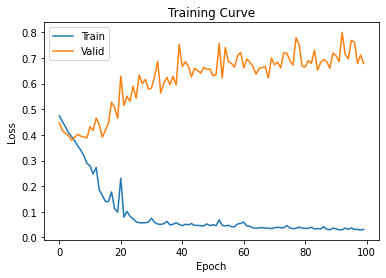

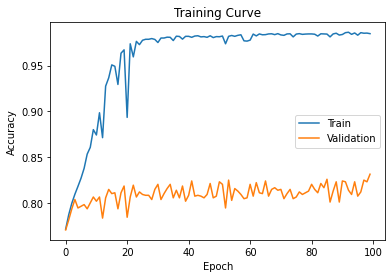

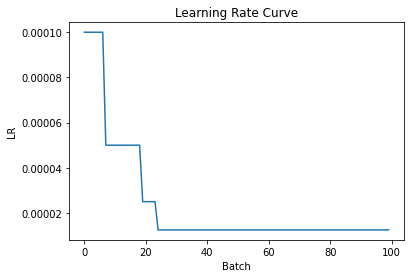

In [62]:
a,b,c,d,e,f,best15,networK15=tune_network(net=IGRatioNet,embedding_size=200, batch_size=64, learning_rate=0.0001, epochs=100, device=device, lstm_layers=1, bidirectional=True, learning_rate_decay=0.5, weight_decay=1e-5, dropout=0.5) # 81.6% val set epoch 12

6520
1086
1087


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


 46/??	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[6491,   29],
        [6155,  365]])
tensor([[1079,    7],
        [1029,   57]])
Epoch: 0, Train Accuracy: 0.71871, Train Loss: 0.56303, Validation Accuracy: 0.69705, Validation Loss: 0.60076, prediction: [0.538, 0.462], true label: [0.0, 1.0]
0.6970534069981584 0
best_state_dict updated
tensor([[5921,  599],
        [3207, 3313]])
tensor([[987,  99],
        [538, 548]])
Epoch: 1, Train Accuracy: 0.77592, Train Loss: 0.47425, Validation Accuracy: 0.75875, Validation Loss: 0.50379, prediction: [0.352, 0.648], true label: [0.0, 1.0]
0.7587476979742173 0.6970534069981584
best_state_dict updated
tensor([[5642,  878],
        [2512, 4008]])
tensor([[932, 154],
        [448, 638]])
Epoch: 2, Train Accuracy: 0.75828, Train Loss: 0.49115, Validation Accuracy: 0.73757, Validation Loss: 0.56086, prediction: [0.648, 0.352], true label: [1.0, 0.0]
0.7375690607734806 0.7587476979742173
tensor([[6079,  441],
        [3408, 3112]])
tensor([[1013,   73],
        [ 579,  507]])
Epoch: 3, Trai

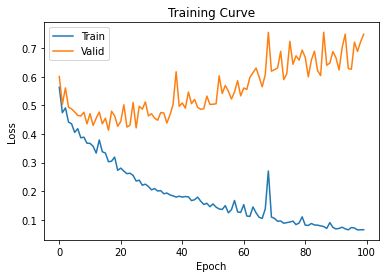

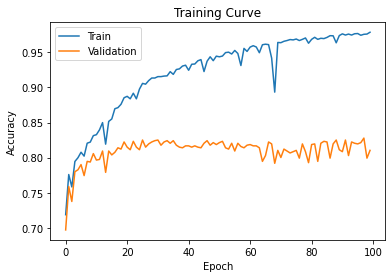

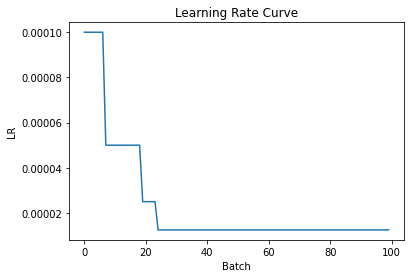

In [138]:
a,b,c,d,e,f,best5,networK5=tune_network(net=IGRatioNet,embedding_size=200, batch_size=64, learning_rate=0.0001, epochs=100, device=device, lstm_layers=1, bidirectional=True, learning_rate_decay=0.5, weight_decay=1e-5, dropout=0.5) # 81.6% val set epoch 12

6520
1087
1087


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


 44/??	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[5938,  582],
        [2717, 3803]])
tensor([[990,  97],
        [451, 636]])
Epoch: 0, Train Accuracy: 0.79479, Train Loss: 0.43693, Validation Accuracy: 0.78933, Validation Loss: 0.43559, prediction: [0.114, 0.886], true label: [0.0, 1.0]
0.7893284268629255 0
best_state_dict updated
tensor([[5993,  527],
        [2416, 4104]])
tensor([[978, 109],
        [418, 669]])
Epoch: 1, Train Accuracy: 0.81334, Train Loss: 0.41620, Validation Accuracy: 0.79209, Validation Loss: 0.39708, prediction: [0.52, 0.48], true label: [1.0, 0.0]
0.7920883164673413 0.7893284268629255
best_state_dict updated
tensor([[6038,  482],
        [2238, 4282]])
tensor([[973, 114],
        [407, 680]])
Epoch: 2, Train Accuracy: 0.83405, Train Loss: 0.37897, Validation Accuracy: 0.80313, Validation Loss: 0.39684, prediction: [0.574, 0.426], true label: [1.0, 0.0]
0.8031278748850046 0.7920883164673413
best_state_dict updated
tensor([[6006,  514],
        [1492, 5028]])
tensor([[945, 142],
        [330, 757]])


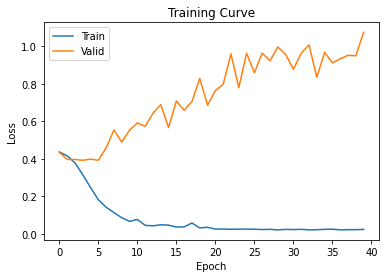

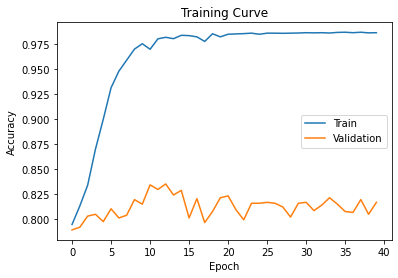

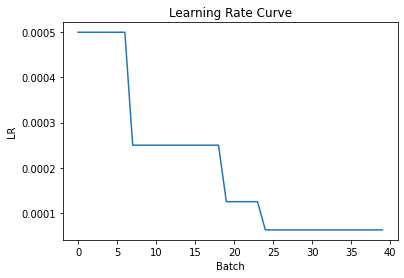

In [63]:
a,b,c,d,e,f,best8,network8=tune_network(net=IGRatioNet,embedding_size=200, batch_size=64, learning_rate=0.0005, epochs=40, device=device, lstm_layers=1, bidirectional=True, learning_rate_decay=0.5, weight_decay=1e-5, dropout=0.5) # 81.6% val set epoch 12

 7/??	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[4866,  836],
        [2115, 3587]])
tensor([[829, 121],
        [351, 599]])
Epoch: 0, Train Accuracy: 0.75798, Train Loss: 0.52029, Validation Accuracy: 0.76526, Validation Loss: 0.49261, prediction: [0.834, 0.166], true label: [1.0, 0.0]
0.7652631578947369 0
best_state_dict updated
tensor([[5071,  631],
        [2012, 3690]])
tensor([[846, 104],
        [346, 604]])
Epoch: 1, Train Accuracy: 0.79814, Train Loss: 0.44432, Validation Accuracy: 0.79474, Validation Loss: 0.44604, prediction: [0.23, 0.77], true label: [0.0, 1.0]
0.7947368421052632 0.7652631578947369
best_state_dict updated
tensor([[5165,  537],
        [2124, 3578]])
tensor([[858,  92],
        [354, 596]])
Epoch: 2, Train Accuracy: 0.81042, Train Loss: 0.43128, Validation Accuracy: 0.79263, Validation Loss: 0.43937, prediction: [0.883, 0.117], true label: [1.0, 0.0]
0.7926315789473685 0.7947368421052632
tensor([[5121,  581],
        [1827, 3875]])
tensor([[848, 102],
        [314, 636]])
Epoch: 3, Train Accuracy

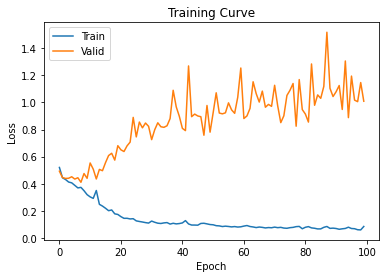

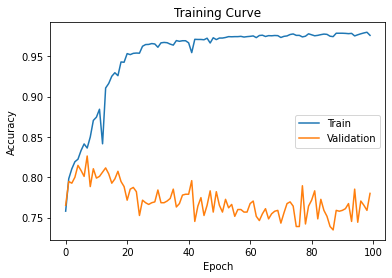

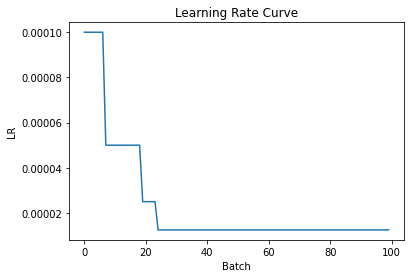

In [83]:
a,b,c,d,e,f,best6,network6=tune_network(net=IGRatioNet,embedding_size=200, batch_size=64, learning_rate=0.0001, epochs=100, device=device, lstm_layers=3, bidirectional=True, learning_rate_decay=0.5, weight_decay=1e-5, dropout=0.5) # 81.6% val set epoch 12

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


 49/??	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[5085,  617],
        [2349, 3353]])
tensor([[855,  95],
        [396, 554]])
Epoch: 0, Train Accuracy: 0.78130, Train Loss: 0.48822, Validation Accuracy: 0.78000, Validation Loss: 0.49032, prediction: [0.868, 0.132], true label: [1.0, 0.0]
0.78 0
best_state_dict updated
tensor([[5004,  698],
        [1800, 3902]])
tensor([[836, 114],
        [296, 654]])
Epoch: 1, Train Accuracy: 0.79674, Train Loss: 0.43506, Validation Accuracy: 0.80842, Validation Loss: 0.44425, prediction: [0.298, 0.702], true label: [0.0, 1.0]
0.8084210526315789 0.78
best_state_dict updated
tensor([[5098,  604],
        [1848, 3854]])
tensor([[846, 104],
        [315, 635]])
Epoch: 2, Train Accuracy: 0.81392, Train Loss: 0.42475, Validation Accuracy: 0.80105, Validation Loss: 0.43938, prediction: [0.923, 0.077], true label: [1.0, 0.0]
0.8010526315789473 0.8084210526315789
tensor([[5076,  626],
        [1656, 4046]])
tensor([[844, 106],
        [282, 668]])
Epoch: 3, Train Accuracy: 0.81585, Train Loss: 0.4

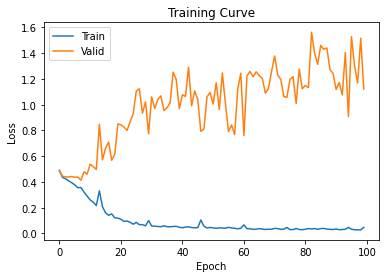

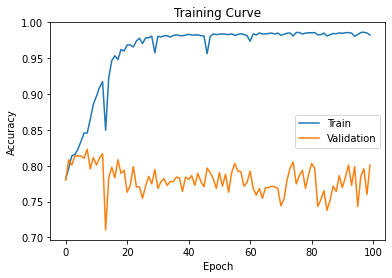

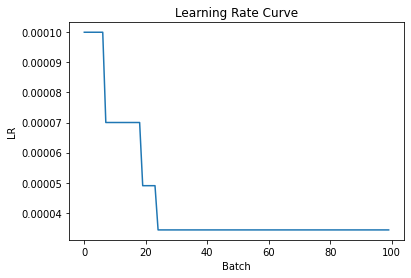

In [84]:
a,b,c,d,e,f,best7,network7=tune_network(net=IGRatioNet,embedding_size=200, batch_size=64, learning_rate=0.0001, epochs=100, device=device, lstm_layers=1, bidirectional=True, learning_rate_decay=0.7, weight_decay=2e-5, dropout=0.5) # 81.6% val set epoch 12

In [134]:
test

In [64]:
test_load2 = TweetBatcher(test, batch_size=64, drop_last=False)
valid_load2 = TweetBatcher(valid, batch_size=64, drop_last=False)
train_load2 = TweetBatcher(train, batch_size=64, drop_last=False)

In [133]:
networK5.load_state_dict(best5)

<All keys matched successfully>

In [136]:
q = get_accuracy(networK5, valid_load2, nn.CrossEntropyLoss())
print(q[0], q[1])

tensor([[841, 109],
        [272, 678]])
0.8231578947368421 0.4121068391121096


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


 46/??	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[5702,    0],
        [5702,    0]])
tensor([[950,   0],
        [950,   0]])
Epoch: 0, Train Accuracy: 0.56822, Train Loss: 0.68160, Validation Accuracy: 0.59684, Validation Loss: 0.67015, prediction: [0.564, 0.436], true label: [1.0, 0.0]
0.5968421052631578 0
best_state_dict updated
tensor([[5702,    0],
        [5702,    0]])
tensor([[950,   0],
        [950,   0]])
Epoch: 1, Train Accuracy: 0.56822, Train Loss: 0.67613, Validation Accuracy: 0.59684, Validation Loss: 0.66096, prediction: [0.574, 0.426], true label: [0.0, 1.0]
0.5968421052631578 0.5968421052631578
tensor([[5702,    0],
        [5702,    0]])
tensor([[950,   0],
        [950,   0]])
Epoch: 2, Train Accuracy: 0.56822, Train Loss: 0.66592, Validation Accuracy: 0.59684, Validation Loss: 0.65350, prediction: [0.596, 0.404], true label: [1.0, 0.0]
0.5968421052631578 0.5968421052631578
tensor([[5683,   19],
        [5502,  200]])
tensor([[946,   4],
        [911,  39]])
Epoch: 3, Train Accuracy: 0.70817, Train Loss:

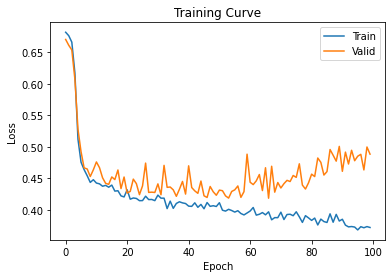

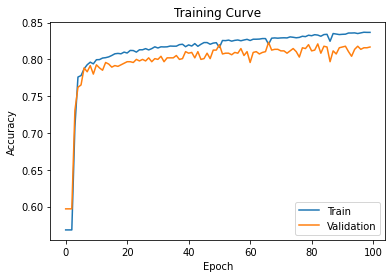

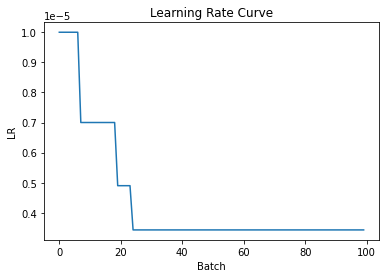

In [137]:
a,b,c,d,e,f,best7,network7=tune_network(net=IGRatioNet,embedding_size=200, batch_size=64, learning_rate=0.00001, epochs=60, device=device, lstm_layers=1, bidirectional=True, learning_rate_decay=0.7, weight_decay=2e-5, dropout=0.5) # 81.6% val set epoch 12

In [ ]:
a,b,c,d,e,f,best11,network11=tune_network(net=IGRatioNet,embedding_size=50, batch_size=64, learning_rate=0.00001, epochs=200, device=device, lstm_layers=1, bidirectional=True, learning_rate_decay=0.7, weight_decay=2e-5, dropout=0.5) # 81.6% val set epoch 12

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


 15/??	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[5702,    0],
        [5702,    0]])
tensor([[950,   0],
        [950,   0]])
Epoch: 0, Train Accuracy: 0.56822, Train Loss: 0.68140, Validation Accuracy: 0.59684, Validation Loss: 0.66891, prediction: [0.567, 0.433], true label: [1.0, 0.0]
0.5968421052631578 0
best_state_dict updated
tensor([[5702,    0],
        [5702,    0]])
tensor([[950,   0],
        [950,   0]])
Epoch: 1, Train Accuracy: 0.56822, Train Loss: 0.67580, Validation Accuracy: 0.59684, Validation Loss: 0.66042, prediction: [0.573, 0.427], true label: [0.0, 1.0]
0.5968421052631578 0.5968421052631578
tensor([[5702,    0],
        [5702,    0]])
tensor([[950,   0],
        [950,   0]])
Epoch: 2, Train Accuracy: 0.56822, Train Loss: 0.66451, Validation Accuracy: 0.59684, Validation Loss: 0.65223, prediction: [0.594, 0.406], true label: [1.0, 0.0]
0.5968421052631578 0.5968421052631578
tensor([[5702,    0],
        [5702,    0]])
tensor([[950,   0],
        [950,   0]])
Epoch: 3, Train Accuracy: 0.71799, Train Loss:

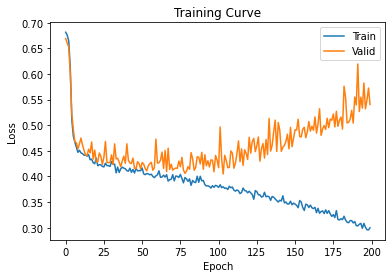

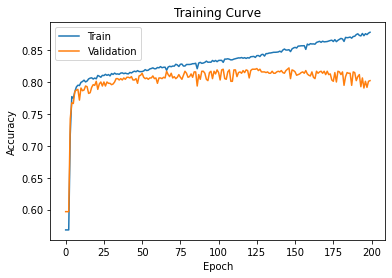

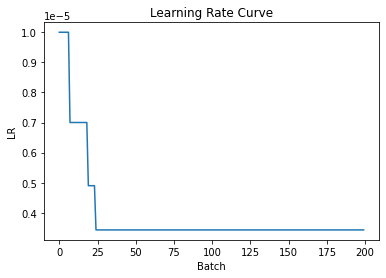

In [144]:
a,b,c,d,e,f,best7,network7=tune_network(net=IGRatioNet,embedding_size=200, batch_size=64, learning_rate=0.00001, epochs=200, device=device, lstm_layers=1, bidirectional=True, learning_rate_decay=0.7, weight_decay=2e-5, dropout=0.5) # 81.6% val set epoch 12

In [140]:
network10 = copy.deepcopy(network7)

In [65]:
networK15.load_state_dict(best15)
q = get_accuracy(networK15, test_load2, nn.CrossEntropyLoss())
print(q[0], q[1])


tensor([[916, 171],
        [233, 854]])
0.8206071757129715 1.0633104082559537


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [66]:
network8.load_state_dict(best8)
q = get_accuracy(network8, test_load2, nn.CrossEntropyLoss())
print(q[0], q[1])


tensor([[940, 147],
        [189, 898]])
0.8509659613615456 0.7947094964571685


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


6520
1087
1087


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


 46/??	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[6520,    0],
        [6520,    0]])
tensor([[1087,    0],
        [1087,    0]])
Epoch: 0, Train Accuracy: 0.53911, Train Loss: 0.68547, Validation Accuracy: 0.55842, Validation Loss: 0.70122, prediction: [0.46, 0.54], true label: [0.0, 1.0]
0.5584176632934683 0
best_state_dict updated
tensor([[6050,  470],
        [3554, 2966]])
tensor([[1014,   73],
        [ 572,  515]])
Epoch: 1, Train Accuracy: 0.76610, Train Loss: 0.49188, Validation Accuracy: 0.76633, Validation Loss: 0.45299, prediction: [0.287, 0.713], true label: [1.0, 0.0]
0.766329346826127 0.5584176632934683
best_state_dict updated
tensor([[6022,  498],
        [3225, 3295]])
tensor([[1015,   72],
        [ 515,  572]])
Epoch: 2, Train Accuracy: 0.78113, Train Loss: 0.46748, Validation Accuracy: 0.77829, Validation Loss: 0.42486, prediction: [0.657, 0.343], true label: [1.0, 0.0]
0.7782888684452622 0.766329346826127
best_state_dict updated
tensor([[5986,  534],
        [2921, 3599]])
tensor([[1008,   79],
        [

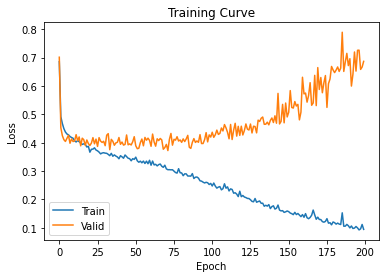

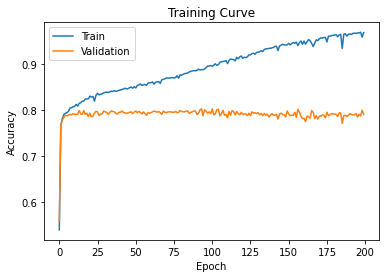

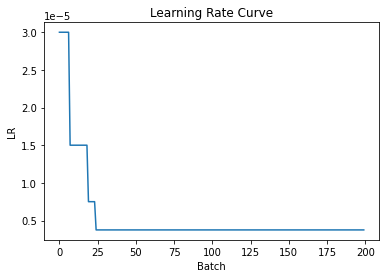

In [71]:
a,b,c,d,e,f,best17,network17=tune_network(net=IGRatioNet,embedding_size=200, batch_size=64, learning_rate=0.00003, epochs=200, device=device, lstm_layers=1, bidirectional=True, learning_rate_decay=0.5, weight_decay=2e-5, dropout=0.5) # 81.6% val set epoch 12

In [70]:
network17.load_state_dict(best17)
q = get_accuracy(network17, test_load2, nn.CrossEntropyLoss())
print(q[0], q[1])

tensor([[990,  97],
        [397, 690]])
0.7985280588776449 0.4674076000228524


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
q[2]

# IGNORE ALL CODE BELOW THIS POINT
To Tune the network run the tune_network function. The function takes in all of the hyperparameters available for tuning which have been implemented. Vary the values and note any models with high validation accuracy.

 913/??	|||||||||
 304/??	|||
Epoch: 0, Train Accuracy: 0.57202, Train Loss: 0.68293, Validation Accuracy: 0.56570, Validation Loss: 0.68778, prediction: [0.595, 0.405], true label: [1.0, 0.0]
 913/??	|||||||||
 304/??	|||
Epoch: 1, Train Accuracy: 0.57202, Train Loss: 0.68189, Validation Accuracy: 0.56570, Validation Loss: 0.68601, prediction: [0.554, 0.446], true label: [1.0, 0.0]
 913/??	|||||||||
 304/??	|||
Epoch: 2, Train Accuracy: 0.57202, Train Loss: 0.67303, Validation Accuracy: 0.56570, Validation Loss: 0.68359, prediction: [0.547, 0.453], true label: [1.0, 0.0]
 913/??	|||||||||
 304/??	|||
Epoch: 3, Train Accuracy: 0.67250, Train Loss: 0.61398, Validation Accuracy: 0.62681, Validation Loss: 0.65184, prediction: [0.583, 0.417], true label: [0.0, 1.0]


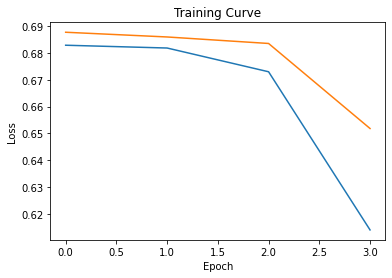

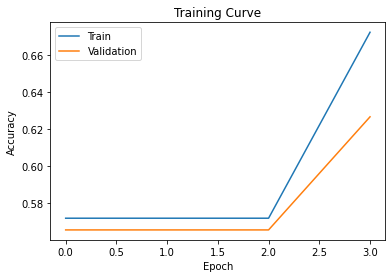

([0.5720227670753065,
  0.5720227670753065,
  0.5720227670753065,
  0.6725043782837128],
 [0.6829329426160647,
  0.6818892047021371,
  0.6730256313692701,
  0.6139797669022394],
 [0.5657030223390276,
  0.5657030223390276,
  0.5657030223390276,
  0.6268068331143233],
 [0.6877802771173025,
  0.686014464419139,
  0.6835889861379799,
  0.6518410842277502],
 [0, 1, 2, 3])

In [ ]:
torch.random.manual_seed(0)
#ratio_net = RatioNet2(input_size=len(tokenised_data.vocab), batch_size=5, device=device)
ratio_net = RatioNet(input_size=len(tokenised_data.vocab), batch_size=5, device=device, embedding_size=200, hidden_size=200, lstm_input_size=300)
#ratio_net =  SpamRNN(input_size=len(tokenised_data.vocab), hidden_size=200, device=device)
#ratio_net =  SpamRNN(input_size=len(tokenised_data.vocab), hidden_size=200, device=device)
#ratio_net = no_conv_RatioNet(input_size=len(tokenised_data.vocab), batch_size=5, device=device)
train_net(ratio_net.to(device), [train_loader,val_loader,test_loader], epochs=4, device=device)
#train_net(ratio_net, sanity_loader, device=device, sanity_check=True, epochs=500 , learning_rate=0.001, adam=True)
#train_network(ratio_net.to(device), train_loader, val_loader, num_epochs=60)

In [ ]:
get_accuracy(ratio_net, val_loader, nn.CrossEntropyLoss())

 0.5657030223390276


(0.5657030223390276, 0.6818610225853167)

In [ ]:
class TweetRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(TweetRNN, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # Look up the embedding
        print(x.shape)
        x = self.emb(x)
        print(x.shape)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
def get_tweet_vectors(glove_vector):
    train, valid, test = [], [], []
    for i, line in enumerate(get_data()):
        tweet = line[-1]
        if i % 59 == 0:
            # obtain an embedding for the entire tweet
            tweet_emb = sum(glove_vector[w] for w in split_tweet(tweet))
            # generate a label: 1 = happy, 0 = sad
            label = torch.tensor(int(line[0] == "4")).long()
            # place the data set in either the training, validation, or test set
            if i % 5 < 3:
                train.append((tweet_emb, label)) # 60% training
            elif i % 5 == 4:
                valid.append((tweet_emb, label)) # 20% validation
            else:
                test.append((tweet_emb, label)) # 20% test
    return train, valid, test

glove = torchtext.vocab.GloVe(name="6B", dim=50)

train, valid, test = get_tweet_vectors(glove)

train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

In [ ]:
text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x,        # because are building a character-RNN
                                  include_lengths=True,        # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)              # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,            # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",                      # fields are separated by a tab
                                        fields)

train, valid, test = dataset.split(split_ratio=[0.6, 0.2, 0.2], random_state=random.seed(0)) #split dateset into 60-20-20
                                                                                             # chunks
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

# an unbalanced dataset may lead to the model learning to always predict the
# most common of the 2 classes, in this case non-spam comments, and still
# getting a good accuracy/low loss. But this doesnt actually teach the model
# what the difference between a spam or a non-spam comment is. In other words,
# an unbalanced set with much less spam data will lead to large false negative
# rate likely close to 100%.
text_field.build_vocab(train)

train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=5,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
valid_iter = torchtext.data.BucketIterator(valid,
                                           batch_size=5,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
test_iter  = torchtext.data.BucketIterator(test,
                                           batch_size=5,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
# save the original training examples

FileNotFoundError: ignored

In [ ]:
#ratio_net = RatioNet(input_size=len(tokenised_data.vocab), batch_size=10)
ratio_net = RatioNet(input_size=len(tokenised_data.vocab), batch_size=10, device=device, embedding_size=200,num_layers=4, hidden_size=200, lstm_input_size=500)

train_net(ratio_net, sanity_loader, device=device, sanity_check=True, epochs=500 , learning_rate=0.001, adam=True)


In [ ]:
#ratio_net = RatioNet(input_size=len(tokenised_data.vocab), batch_size=10)
ratio_net = RatioNet(input_size=len(tokenised_data.vocab), batch_size=10, device=device, embedding_size=50,num_layers=1, hidden_size=50, lstm_input_size=500)

train_net(ratio_net, sanity_loader, device=device, sanity_check=True, epochs=200 , learning_rate=10, adam=False)


In [ ]:
#ratio_net = RatioNet(input_size=len(tokenised_data.vocab), batch_size=10)
ratio_net = no_conv_RatioNet(input_size=len(tokenised_data.vocab), batch_size=10, device=device, embedding_size=50,num_layers=1, hidden_size=50, lstm_input_size=50)

train_net(ratio_net, sanity_loader, device=device, sanity_check=True, epochs=200 , learning_rate=0.01, adam=False)


In [ ]:
#ratio_net = RatioNet(input_size=len(tokenised_data.vocab), batch_size=10)
ratio_net = no_lstm_RatioNet(input_size=len(tokenised_data.vocab), batch_size=10, device=device, embedding_size=50,num_layers=1, hidden_size=50, lstm_input_size=50)

train_net(ratio_net, sanity_loader, device=device, sanity_check=True, epochs=200 , learning_rate=0.01, adam=False)

In [ ]:
#ratio_net = RatioNet(input_size=len(tokenised_data.vocab), batch_size=10)
ratio_net = RatioNet2(input_size=len(tokenised_data.vocab), batch_size=10, device=device, embedding_size=50,num_layers=1, hidden_size=50, lstm_input_size=50)

train_net(ratio_net, sanity_loader, device=device, sanity_check=True, epochs=200 , learning_rate=0.000000001, adam=True, weight_decay=0)

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
_onehot_tweets = torch.eye(len(tokenised_data.vocab))
onehot_labels = torch.eye(2)

def train_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5):
    #criterion = nn.CrossEntropyLoss()
    #criterion = nn.HuberLoss()
    #criterion = nn.L1Loss()
    #criterion = nn.BCEWithLogitsLoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    train_acc = []
    valid_acc = []
    for epoch in range(num_epochs):
        loss_sum = 0
        total = 0
        for tweets, labels in train_loader:
            #print(tweets.shape)
            #print(labels.shape)
            tweets, labels = tweets.type(torch.LongTensor).to(device), onehot_labels[labels.type(torch.LongTensor)].to(device)   # onehot_tweets[tweets.type(torch.LongTensor)].to(device)
            #print(tweets.shape)
            #print(labels.shape)            #print(tweets.shape)
            #tweets = tweets.to(device)
            #labels = labels.to(device)
            optimizer.zero_grad()
            #if epoch == 4:
            #  print(tweets.shape)
            pred = model(tweets)
            loss = criterion(pred, labels) #torch.sqrt(criterion(pred, labels))
            loss.backward()
            optimizer.step()
            loss_sum += float(loss)
            total += 1
        train_acc.append(get_accuracy(model, train_loader, criterion)[0])
        valid_acc.append(get_accuracy(model, valid_loader, criterion)[0])
        epochs.append(epoch)
        losses.append(loss_sum/total)     
        print(f"Epoch: {epoch}, Train Loss: {loss_sum/total}, Train Acc: {train_acc[epoch]} Validation Loss: [not yet available], prediction: {F.softmax(pred[-1])}, true ratio: {labels[-1]}")
    print(len(train_acc))
              #if epoch % 5 == 4:
        #    epochs.append(epoch)

        #    print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
         #       epoch+1, loss, train_acc[-1], valid_acc[-1]))
        #print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
        #       epoch+1, loss, train_acc[-1], valid_acc[-1]))
        #print(f"Epoch: {epoch}, Train Loss: {loss}, Validation Loss: [not yet available], prediction: {pred[-1]}, true ratio: {labels[-1]}")

    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

# def get_accuracy(model, data_loader):
#     correct, total = 0, 0
#     for tweets, labels in data_loader:
#         output = model(tweets)
#         pred = output.max(1, keepdim=True)[1]
#         correct += pred.eq(labels.view_as(pred)).sum().item()
#         total += labels.shape[0]

#     return correct / total